![](face.png)

# 深度學習 - 臉部識別

## Colab環境設置

這裡我們來練習一個很好用並且很有名的函式庫，face-recognition函式庫，由於官方目前只保證非Windows系統的支援(但其實如果要也是可以在Windows安裝)，所以我們使用colab來使用這個函式庫，沒用過colab的同學也不用慌張，只要在Google輸入colab就可以很直覺的開始使用Colab

## 需要函式庫

1. dlib: 被廣泛使用的C深度學習函式庫  
2. face_recognition: 包裝dlib函式庫成python api讓我們可以方便使用，讀者請參考 <https://github.com/ageitgey/face_recognition>

我們在使用colab的時候可以直接安裝face_recognition即可

## 臉部識別知識

深度學習中一個很重要的概念叫做『降維』，face_recognition正是使用了『降維』的概念將一個複雜的臉部降低為128維度的向量，接著再使用距離公式來比較臉的距離，越近的就會是我們的答案！

![圖: face_recognition基本原理](facerecog.png)

利用降維來做臉部識別的優點是我們就不用每次需要辨認新的臉就重新訓練『辨別網路』了，而是利用一個原本已經訓練過許多人臉辨識的網路的前半部分(卷積)來對所有的臉做出特徵的萃取，並利用『特徵距離的遠近』完成辨識

## 臉部距離

這裡直接使用兩個128維度的向量求歐式距離

歐式距離: 我們平常常用的平方距離 $\sqrt{(x_1 - x_2)^2 +(y_1 - y_2)^2}$



## 開始寫程式

了解了face_recognition基本原理後就可以開始寫程式了


### Step 0. 在Colab環境上安裝函式庫

由於face_recognition牽涉C的函式庫，為了讓C函式庫可以成功編譯，所以我在colab環境使用apt(Linux的套件管理)安裝了cmake，接著再透過pip(Python的套件管理)安裝face_recognition即可

In [ ]:
# 在notebook, !開頭代表是執行作業系統裡的軟體, 而非python程式碼
!apt update
!apt install -y cmake
!pip install face_recognition

### Step 1. 掛載Google Drive

由於colab每次使用都是一次性的機器，所以我們掛載我們自己的Google Drive當作儲存的硬碟！你可以想像成把Google Drive當成一片光碟插入並且給這個儲存媒介一個名字/gdrive，在掛載的時候會看到以下的圖，請登入並輸入得到的驗證碼在下面

![圖: 掛載Google Drive時輸入驗證碼](oauth.png)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

### Step 2. 準備樣本照片以及辨識照片

我在我的Google Drive準備了known_person(樣本照片)以及unknown_person(辨識照片)，結構如下

![圖: 我的資料集](drive.png)

如果有需要參考的同學:

known_person: <https://drive.google.com/open?id=1JW9R_JQLRGe7nfvSPTb03oqkFvsREe0_>

unknown_person: <https://drive.google.com/open?id=171j0YaGP1YY5EHpN_KTG-znw9nuGjdd3>

另外我已經在known_person的每個檔案名字上標上了明星的名字，這裡請先使用英文會比較容易點，因為到時候我們要將框框放上去寫字的時候，預設只支援英文字型，當然讀者可以自行試試看將中文字型替換上去

In [3]:
import glob
# https://drive.google.com/open?id=1JW9R_JQLRGe7nfvSPTb03oqkFvsREe0_
# 大家預設的資料夾會從(我的雲端硬碟)也就是My Drive開始
flist = glob.glob("/gdrive/My Drive/known_person/*")
flist

['/gdrive/My Drive/known_person/Eason.jpg',
 '/gdrive/My Drive/known_person/Jay.jpg',
 '/gdrive/My Drive/known_person/Chiling.jpeg',
 '/gdrive/My Drive/known_person/Yui.jpg']

In [5]:
import glob
# https://drive.google.com/open?id=171j0YaGP1YY5EHpN_KTG-znw9nuGjdd3
unknown_flist = glob.glob("/gdrive/My Drive/unknown_person/*")
unknown_flist

['/gdrive/My Drive/unknown_person/unknown2.jpg',
 '/gdrive/My Drive/unknown_person/unknown3.jpg',
 '/gdrive/My Drive/unknown_person/unknown1.jpeg',
 '/gdrive/My Drive/unknown_person/unknown6.jpg',
 '/gdrive/My Drive/unknown_person/unknown7.jpeg',
 '/gdrive/My Drive/unknown_person/unknown8.jpg',
 '/gdrive/My Drive/unknown_person/unknown9.jpg',
 '/gdrive/My Drive/unknown_person/unknown10.jpg',
 '/gdrive/My Drive/unknown_person/unknown5.jpg',
 '/gdrive/My Drive/unknown_person/unknown4.jpeg']

### Step 3. 處理樣本圖片

我們將樣本圖片轉換成128維度的向量並且儲存至list裡，以便後續的對照，這裡由於我們還順便將所有樣品照片畫出來，所以程式碼會稍嫌複雜

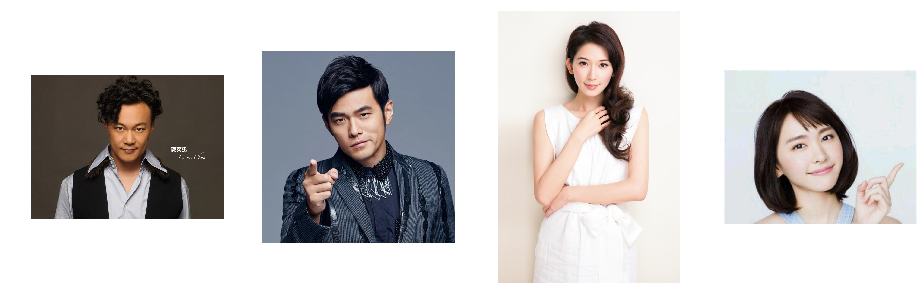

In [6]:
import face_recognition
# 讀者如果在這出錯, 請額外安裝opencv-python
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
# 最後要記錄出的樣品向量(128維度)和標籤(明星名)
encodinglist = []
labels = []

# 一橫列畫幾個人
width = 5
# 總共幾個橫列
height = int(len(flist) / width) + 1
# 整個大圖的size
plt.figure(figsize=(20, 5))
for (i, f) in enumerate(flist):
  # Step1. 讀取檔案
  img = face_recognition.load_image_file(f)
  # Step2. 把臉的降維向量算出, 用已經做好的cnn, [0]第一張臉
  face_encoding = face_recognition.face_encodings(img)[0]
  # Step3. 抓出臉的方框, 我們這裡沒用到, 但如果你想畫框就會需要
  # 這裡的face_locations可以使用cnn(深度學習)或者haar(固定特徵)來得到
  # 如果需要快速, 請使用haar, 如果需要更準確, 就使用cnn, 建議可以使用預設haar即可
  (top, right, bottom, left) = face_recognition.face_locations(img, model="cnn")[0]
  # Step4. 把它加到我自己準備的list裡
  encodinglist.append(face_encoding)
  # Step5. 把檔名前面的人名split出來
  name = os.path.split(f)[-1].split(".")[0]
  # Step6. 把人名到我自己準備的list
  labels.append(name)
  # 利用enumerate得到的i指定subplot
  plt.subplot(height, width, i + 1)
  plt.axis("off")
  plt.imshow(img)

我們可以秀出一下剛剛轉換出的128維度的樣子

In [8]:
# 秀一下志玲的臉降維過後的向量
print("維度:", len(encodinglist[2]))
encodinglist[2]

維度: 128


array([-0.04509995,  0.02732677,  0.12371893, -0.07578276, -0.12690797,
       -0.02014865, -0.10275003, -0.09153799,  0.13545716, -0.206947  ,
        0.25439918, -0.07709686, -0.17507979, -0.0281685 , -0.08011092,
        0.20661798, -0.20426925, -0.20284776, -0.05412045,  0.04327367,
        0.07854962,  0.04034478, -0.01418125,  0.04357049, -0.10654324,
       -0.36549333, -0.05965845, -0.03572623,  0.03467788, -0.12136632,
       -0.11177415,  0.00897156, -0.20707254, -0.00466768,  0.03816228,
        0.15581629,  0.04378108, -0.20787092,  0.11183376, -0.00653949,
       -0.37158719,  0.04260344,  0.05478306,  0.17682055,  0.18219377,
       -0.02709193, -0.04261389, -0.21085964,  0.1505862 , -0.19165377,
        0.02137787,  0.10095289,  0.11072782,  0.05710011,  0.01255718,
       -0.15987188,  0.03314116,  0.16100316, -0.17165169, -0.03669654,
        0.02461205, -0.05417454,  0.08733688, -0.14498684,  0.18324921,
        0.13916758, -0.09947963, -0.25419059,  0.14428286, -0.18

### Step 4. 預測照片

非常輕鬆簡單就可以完成預測，其實跟樣品照片的程式碼並沒有差距太多

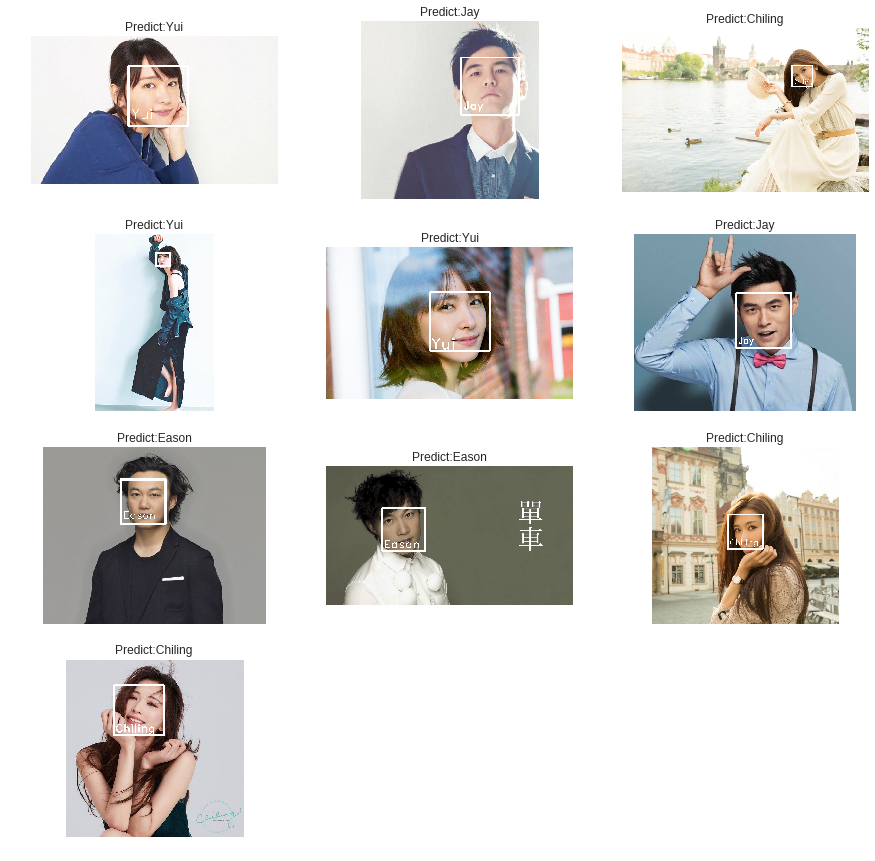

In [35]:
import numpy as np
plt.figure(figsize=(15, 15))
width = 3
height = int(len(unknown_flist) / width) + 1
for (i, f) in enumerate(unknown_flist):
  img = face_recognition.load_image_file(f)
  face_encoding = face_recognition.face_encodings(img)[0]
  # (top, right, bottom, left)
  (top, right, bottom, left) = face_recognition.face_locations(img)[0]
  # rectangle(要畫的圖, 左上座標, 右下座標, 顏色, 粗細)
  size = int(img.shape[0] / 100)
  cv2.rectangle(img, (left, top), (right, bottom), (255, 255, 255), size)
  font = cv2.FONT_HERSHEY_DUPLEX
  # face_distance->算跟妳傳進去的encodinglist每一個距離
  results = face_recognition.face_distance(encodinglist, face_encoding)
  # 這裡使用argmin(axis=-1)稍微難一點, 是得到群集裡最小值的index部分
  name = labels[np.array(results).argmin(axis=-1)]
  labels.append(name)
  # 把文字放到我的圖上, 文字放在框右移6, 上移15的位置
  # putText(圖片, 標籤, 起始座標, 字型, 字型大小, 顏色, 粗細)
  # 這裡我有刻意根據框的大小調整字體大小, 如果讀者沒特別需求可以都設成1
  cv2.putText(img, name, (left + 6, bottom - 15), 
              font, (right-left)//100 , 
              (255, 255, 255), (right-left)//75)
  plt.subplot(height, width, i + 1)
  plt.title("Predict:" +  name)
  plt.axis("off")
  plt.imshow(img)

### Step 5. 結論

你可以看到我們在上面的預測真的是非常非常地準確，基本上沒有出任何錯，為什麼可以這麼準確呢？因為我們是用距離在衡量到底跟誰比較像！如果你有需要你也可以設定一定的threshold，讓她要在某一個距離內才判定是有偵測到，最後我們把最後一張圖所有的distance列出來，最後一張是『林志玲』的圖，你會發現理所當然地和自己最近，但第二近的就會是『新垣結衣』，而和男性的距離就會較遠，所以利用『距離』真的是可以看出『相似度』的！

In [37]:
# 妳可以把跟所有臉的距離列出來, 最小值基本上就是我們的答案
img = face_recognition.load_image_file(unknown_flist[-1])
face_encoding = face_recognition.face_encodings(img)[0]
results = face_recognition.face_distance(encodinglist, face_encoding)
for (i, r) in enumerate(results):
  print("和", labels[i], "的距離:", r)

和 Eason 的距離: 0.6621559889113561
和 Jay 的距離: 0.6811733539341673
和 Chiling 的距離: 0.39850771528251855
和 Yui 的距離: 0.5108713051423769


## 你還可以做什麼？

舉凡找出『跟本人最相似的明星』，『兩個人長的相似程度』，幾乎所以跟面部有關的主題，你都可以來試試看唷！